In [1]:
import glob
import cv2
import numpy as np

DATA_DIR = "./dataset/"
IMG_SIZE = 256
NUM_FRAMES_PER_VIDEO = 16
targets = {"1": 0, "2": 0, "3": 1, "4": 1, "5": 2, "6": 2, "7": 3, "8": 3, "HR_1": 0, "HR_2": 1, "HR_3": 2, "HR_4": 3}

def video2frames(video_path, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    is_there_frame = True
    num_total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) 
    resampling_rate = int(num_total_frames / NUM_FRAMES_PER_VIDEO)
    idf = 0
    while is_there_frame and len(frames)<NUM_FRAMES_PER_VIDEO:
        idf = idf + 1
        is_there_frame, frame = cap.read()
        if frame is None:
            return np.array([])
        if idf % resampling_rate == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, resize)
            frames.append(frame)
    assert len(frames)==NUM_FRAMES_PER_VIDEO
    return np.stack((np.array(frames),)*3, axis=-1)

def load_casia_dataset(SUB_DIR):
    try:
        dataset_x = []
        dataset_y = []   
        files = glob.glob(f'{DATA_DIR}/{SUB_DIR}/**/*.avi', recursive=True)
        for f in files:
            frames = video2frames(f)
            if frames.size == 0:
                continue
            dataset_x = [*dataset_x, *frames]
            dataset_x = np.array(dataset_x)
            vector_path = f.split("/")
            tmp = [targets[vector_path[-1][:-4]]]*NUM_FRAMES_PER_VIDEO
            dataset_y = [*dataset_y, *tmp]
    except LookupError: # IndexError, KeyError
        print("index from video name not found in map targets")
    return dataset_x, dataset_y

In [2]:
x_train, y_train = load_casia_dataset("train_release")
x_test, y_test = load_casia_dataset("test_release")

In [3]:
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

BATCH_SIZE = 64
VAL_SIZE = int(len(x_train)*0.15)
TRAIN_SIZE = len(x_train) - VAL_SIZE

class CasiaDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)
        
        return x, y

transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])])
train_dataset = CasiaDataset(x_train[:TRAIN_SIZE], y_train[:TRAIN_SIZE], transform=transform)
validation_dataset = CasiaDataset(x_train[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE], y_train[TRAIN_SIZE:VAL_SIZE+TRAIN_SIZE], transform=transform)
test_dataset = CasiaDataset(x_test, y_test, transform=transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=int(BATCH_SIZE/2), shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


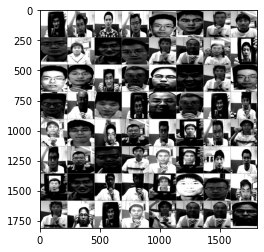

In [4]:
import torchvision
import matplotlib.pyplot as plt

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(train_dataloader)
images, label = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [5]:
import torch.nn as nn

alex_net_model = torchvision.models.alexnet(pretrained = True)

alex_net_model.classifier[4] = nn.Linear(4096, 1024)
alex_net_model.classifier[6] = nn.Linear(1024, 4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

alex_net_model.to(device) # use cuda if available

/home/paolo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paolo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(alex_net_model.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 10

def train():
    for epoch in range(EPOCHS):
        running_loss = 0.0
        for _, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = alex_net_model(inputs)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print("Epoch:[", epoch+1, "/", EPOCHS, "] training_loss_value =", running_loss)

        # VALIDATION
        with torch.no_grad():
            correct_aux = 0
            total = 0
            for data in validation_dataloader:
                images, labels = data[0].to(device), data[1].to(device)
                images = images.to(device)
                labels = labels.to(device)
                outputs = alex_net_model(images)
                loss = loss_function(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += len(labels)
                correct_aux += (predicted == labels).sum().item()
            
        
            val_loss = loss.detach().cpu()
            print("validation_loss_value =", val_loss, "accuracy =", float(float(correct_aux/total)*100))

train()
print('Finished Training of AlexNet')
        

Epoch:[ 1 / 10 ] training_loss_value = 32.73353058099747
validation_loss_value = tensor(1.7312) accuracy = 88.2661996497373
Epoch:[ 2 / 10 ] training_loss_value = 4.05362331867218
validation_loss_value = tensor(1.7704) accuracy = 93.16987740805604
Epoch:[ 3 / 10 ] training_loss_value = 1.574050301220268
validation_loss_value = tensor(2.3082) accuracy = 94.04553415061297
Epoch:[ 4 / 10 ] training_loss_value = 1.1612529695266858
validation_loss_value = tensor(1.2997) accuracy = 94.57092819614711
Epoch:[ 5 / 10 ] training_loss_value = 0.6617685451637954
validation_loss_value = tensor(1.7666) accuracy = 94.04553415061297
Epoch:[ 6 / 10 ] training_loss_value = 0.4880959923611954
validation_loss_value = tensor(1.3187) accuracy = 94.7460595446585
Epoch:[ 7 / 10 ] training_loss_value = 0.2822879522573203
validation_loss_value = tensor(3.5513) accuracy = 92.11908931698774
Epoch:[ 8 / 10 ] training_loss_value = 0.5022996799671091
validation_loss_value = tensor(1.1340) accuracy = 93.8704028021015

In [8]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alex_net_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy on the", len(test_dataloader), "test images", float(float(correct/total)*100))

Accuracy on the 90 test images 88.77089136490251


In [9]:
torch.save(alex_net_model, "model.pt")